In [1]:
import sys
import math

from PIL import Image

import numpy as np

from pyvox.models import Vox
from pyvox.writer import VoxWriter
from pyvox.parser import VoxParser

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D

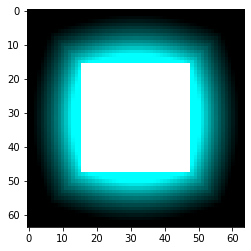

(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)
(0, 0, 0, 255)
(255, 255, 255, 255)
(255, 255, 255, 255)
(255, 255, 255, 255)
(255, 255, 255, 255)


In [2]:
src_base_w = 32
src_base_h = 32
border = 16

h0 = src_base_w / 2. + border - 0.5
v0 = src_base_h / 2. + border - 0.5

def draw_tile(pixels, points, hbase, vbase):
    for voff in range(src_base_h + 2*border):
        for hoff in range(src_base_w + 2*border):

            ur = (float(hoff) - h0) / float(src_base_w)
            vr = (float(voff) - v0) / float(src_base_h)
            
            hlevel = 0
            for up, vp in points:
                u = (ur - up)
                v = (vr - vp)
                d_euc = math.sqrt(u*u + v*v)
                d_max = max(abs(u), abs(v))
                d = ( d_euc + d_max ) / 2.0
                
                if d > 0.1:
                    i = min(1.0, max(0, 1.0 / math.pow(d - 0.1, 1.1) / 1.0 - 1.2 ))
                    #i = min(1.0, max(0, 1.0 / math.pow(d, 1.6) / 1.0 - 1.1 ))
                else:
                    i = 1.0
                hlevel += i
                    
            hlevel = min(1, max(0, hlevel))

            if hoff >= border and hoff < src_base_w + border and \
               voff >= border and voff < src_base_h + border:
                r, g, b = hlevel * 128, hlevel * 128, hlevel * 128
            else:
                r, g, b = hlevel * 0, hlevel * 128, hlevel * 128

            f = 2
            pixels[hbase + hoff, vbase + voff] = ( int(r * f), int(g * f), int(b * f), int(255) )

            
points = [ (0, 0) ]
vbase = 0
hbase = 0

img = Image.new('RGBA', (src_base_w + border * 2, src_base_h + border * 2), (0, 0, 0, 0))
pixels = img.load()
draw_tile(pixels, points, hbase, vbase)
plt.imshow(img)
plt.show()

print(img.getpixel((0, 0)))
print(img.getpixel((src_base_w + 2*border - 1, 0)))
print(img.getpixel((0, src_base_h + 2*border - 1)))
print(img.getpixel((src_base_w + 2*border - 1, src_base_h + 2*border - 1)))

print(img.getpixel((src_base_w / 2 + border - 1, 0)))
print(img.getpixel((0, src_base_h / 2 + border - 1)))
print(img.getpixel((src_base_w / 2 + border - 1, src_base_h + 2*border - 1)))
print(img.getpixel((src_base_w + 2*border - 1, src_base_h / 2 + border - 1)))

print(img.getpixel((0 + border, 0 + border)))
print(img.getpixel((src_base_w + border - 1, 0 + border)))
print(img.getpixel((0 + border, src_base_h + border - 1)))
print(img.getpixel((src_base_w + border - 1, src_base_h + border - 1)))


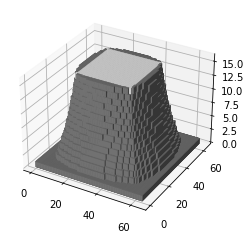

In [3]:
max_hlevel = 16

voxels = np.zeros((src_base_w + 2*border, src_base_h + 2*border, max_hlevel), dtype=bool)
colors = np.zeros((src_base_w + 2*border, src_base_h + 2*border, max_hlevel) + (4,))

for voff in range(src_base_h + 2*border):
      for hoff in range(src_base_w + 2*border):
            rmap, gmap, bmap, amap = img.getpixel((hoff, voff))
            vmap = max(rmap, gmap, bmap) # Convert to Grey
            if vmap <= 1: vmap = 0
            hlevel = int(vmap / 16)

            for z in range(hlevel + 1):
                voxels[hoff, voff, z] = bool(1)
                
                if hoff >= border and hoff < src_base_w + border and \
                   voff >= border and voff < src_base_h + border:
                        colors[hoff, voff, z] = (1.0, 1.0, 1.0, 1.0)
                else:
                        colors[hoff, voff, z] = (0.5, 0.5, 0.5, 1.0)

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(voxels,
              facecolors=colors,
              edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
              linewidth=0.5)
plt.show()

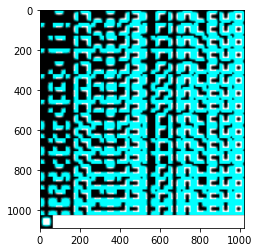

In [16]:
tiles_per_line = 16
last_tile = 0x101 # 0x200

tiles_img = Image.new('RGBA',
    ( (src_base_w + border * 2) * tiles_per_line,
      (src_base_h + border * 2) * ((last_tile + tiles_per_line - 1) // tiles_per_line)) ,
    (0, 0, 0, 0)
)

tiles_info = []

pixels = tiles_img.load()

for b in range(last_tile):
    points = [ ]
    if ( b >> 8 ) & 1 != 0:    points.append((0, 0))
    if ( b >> 0 ) & 1 != 0:    points.append((0, -1))
    if ( b >> 1 ) & 1 != 0:    points.append((1, 0))
    if ( b >> 2 ) & 1 != 0:    points.append((0, 1))
    if ( b >> 3 ) & 1 != 0:    points.append((-1, 0))
    if ( b >> 4 ) & 1 != 0:    points.append((-1, -1))
    if ( b >> 5 ) & 1 != 0:    points.append((1, -1))
    if ( b >> 6 ) & 1 != 0:    points.append((1, 1))
    if ( b >> 7 ) & 1 != 0:    points.append((-1, 1))

    hbase = (b % tiles_per_line) * (src_base_w + 2*border)
    vbase = (b // tiles_per_line) * (src_base_h + 2*border)
    draw_tile(pixels, points, hbase, vbase)
    #print(b, hbase, vbase)
    
    tiles_info.append({
        'id': b,
        'XCoord': hbase + border,
        'YCoord': vbase + border,
    })

plt.imshow(tiles_img)
plt.show()

tiles_img.save("VoxTest6_A.png", format="png")

In [17]:
tiles_info

[{'id': 0, 'XCoord': 16, 'YCoord': 16},
 {'id': 1, 'XCoord': 80, 'YCoord': 16},
 {'id': 2, 'XCoord': 144, 'YCoord': 16},
 {'id': 3, 'XCoord': 208, 'YCoord': 16},
 {'id': 4, 'XCoord': 272, 'YCoord': 16},
 {'id': 5, 'XCoord': 336, 'YCoord': 16},
 {'id': 6, 'XCoord': 400, 'YCoord': 16},
 {'id': 7, 'XCoord': 464, 'YCoord': 16},
 {'id': 8, 'XCoord': 528, 'YCoord': 16},
 {'id': 9, 'XCoord': 592, 'YCoord': 16},
 {'id': 10, 'XCoord': 656, 'YCoord': 16},
 {'id': 11, 'XCoord': 720, 'YCoord': 16},
 {'id': 12, 'XCoord': 784, 'YCoord': 16},
 {'id': 13, 'XCoord': 848, 'YCoord': 16},
 {'id': 14, 'XCoord': 912, 'YCoord': 16},
 {'id': 15, 'XCoord': 976, 'YCoord': 16},
 {'id': 16, 'XCoord': 16, 'YCoord': 80},
 {'id': 17, 'XCoord': 80, 'YCoord': 80},
 {'id': 18, 'XCoord': 144, 'YCoord': 80},
 {'id': 19, 'XCoord': 208, 'YCoord': 80},
 {'id': 20, 'XCoord': 272, 'YCoord': 80},
 {'id': 21, 'XCoord': 336, 'YCoord': 80},
 {'id': 22, 'XCoord': 400, 'YCoord': 80},
 {'id': 23, 'XCoord': 464, 'YCoord': 80},
 {'id'

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def bezier_gradient(ref_colors, output_num=100):
    n_ref = len(ref_colors) - 1

    fact_cache = {}
    def fact(n):
        ''' Memorized factorial function '''
        try:
            return fact_cache[n]
        except(KeyError):
            if n == 1 or n == 0:
                result = 1
            else:
                result = n*fact(n-1)
            fact_cache[n] = result
            return result

    def bernstein(t, n, i):
        ''' Bernstein coefficient '''
        binom = fact(n)/float(fact(i)*fact(n - i))
        return binom*((1-t)**(n-i))*(t**i)

    def bezier_interp(t):
            ''' Define an interpolation function
                for this specific curve'''
            # List of all summands
            summands = [
                list(map(lambda x: int(bernstein(t, n_ref, i)*x), c)) for i, c in enumerate(ref_colors)
            ]

            # Output color
            out = [0,0,0]
            # Add components of each summand together
            for vector in summands:
                for c in range(3):
                    out[c] += vector[c]

            return out

    gradient = [
        bezier_interp(float(t)/(output_num-1)) for t in range(output_num)
    ]
    return gradient

In [19]:
def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]


def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
                        "{0:x}".format(v) for v in RGB])

def color_dict(gradient):
    ''' Takes in a list of RGB sub-lists and returns dictionary of
        colors in RGB and hex form for use in a graphing function
        defined later on '''
    return {"hex": [RGB_to_hex(RGB) for RGB in gradient],
            "r":   [RGB[0] for RGB in gradient],
            "g":   [RGB[1] for RGB in gradient],
            "b":   [RGB[2] for RGB in gradient]}

def control_points_from_colors(gradient):
    return {"hex": [RGB_to_hex(RGB) for RGB in gradient],
            "r":   [RGB[0] for RGB in gradient],
            "g":   [RGB[1] for RGB in gradient],
            "b":   [RGB[2] for RGB in gradient]}

def plot_gradient_series(color_dict, pointsize=100, control_points=None, filename=None):
        ''' Take a dictionary containing the color
            gradient in RBG and hex form and plot
            it to a 3D matplotlib device '''

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        xcol = color_dict["r"]
        ycol = color_dict["g"]
        zcol = color_dict["b"]

        # If bezier control points passed to function,
        # plot along with curve
        if control_points != None:
            xcntl = control_points["r"]
            ycntl = control_points["g"]
            zcntl = control_points["b"]
            ax.scatter( xcntl, ycntl, zcntl,
                        c=control_points["hex"],
                        s=pointsize, marker='s')

        # We can pass a vector of colors corresponding to each point
        ax.scatter(xcol, ycol, zcol, c=color_dict["hex"], s=pointsize)

        ax.set_xlabel('Red Value')
        ax.set_ylabel('Green Value')
        ax.set_zlabel('Blue Value')
        ax.set_zlim3d(0,255)
        plt.ylim(0,255)
        plt.xlim(0,255)

        if not filename is None:
            # Save two views of each plot
            ax.view_init(elev=15, azim=68)
            plt.savefig(filename + ".svg")
            ax.view_init(elev=15, azim=28)
            plt.savefig(filename + "_view_2.svg")

        # Show plot for testing
        plt.show()

[(0, 0, 255), (0, 230, 64), (255, 203, 5)]
[[0, 0, 255], [1, 28, 229], [4, 56, 205], [10, 81, 183], [18, 103, 162], [28, 124, 141], [40, 142, 121], [55, 158, 104], [72, 171, 87], [91, 183, 71], [113, 192, 58], [137, 198, 45], [163, 202, 33], [191, 205, 21], [222, 204, 12], [255, 203, 5]]


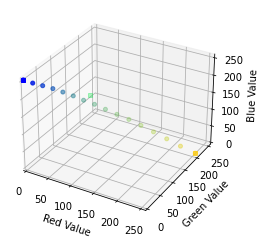

In [20]:
ref_colors = [(0,0,255), (0, 230, 64), (255, 203, 5)]

print(ref_colors)
num_colors = 256 // 16

gradient = bezier_gradient(ref_colors, num_colors)
print(gradient)

plot_gradient_series(color_dict(gradient),
                     pointsize=num_colors,
                     control_points=control_points_from_colors(ref_colors)
                    )

{'id': 0, 'XCoord': 16, 'YCoord': 16}


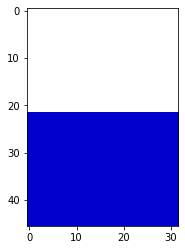

{'id': 1, 'XCoord': 80, 'YCoord': 16}


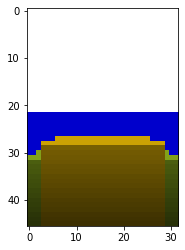

{'id': 2, 'XCoord': 144, 'YCoord': 16}


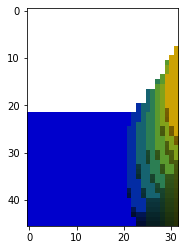

{'id': 3, 'XCoord': 208, 'YCoord': 16}


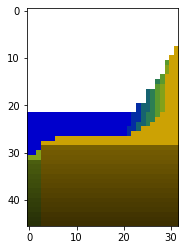

{'id': 4, 'XCoord': 272, 'YCoord': 16}


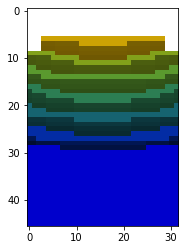

{'id': 5, 'XCoord': 336, 'YCoord': 16}


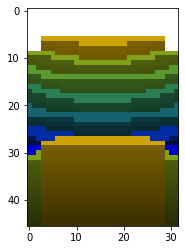

{'id': 6, 'XCoord': 400, 'YCoord': 16}


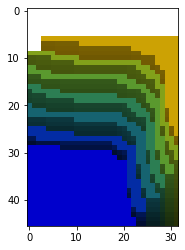

{'id': 7, 'XCoord': 464, 'YCoord': 16}


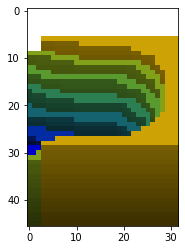

{'id': 8, 'XCoord': 528, 'YCoord': 16}


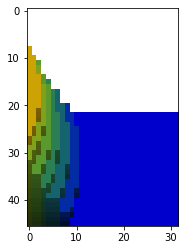

{'id': 9, 'XCoord': 592, 'YCoord': 16}


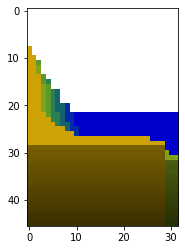

{'id': 10, 'XCoord': 656, 'YCoord': 16}


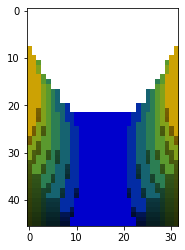

{'id': 11, 'XCoord': 720, 'YCoord': 16}


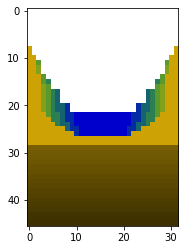

{'id': 12, 'XCoord': 784, 'YCoord': 16}


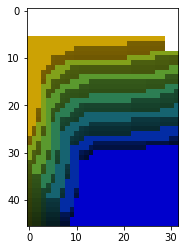

{'id': 13, 'XCoord': 848, 'YCoord': 16}


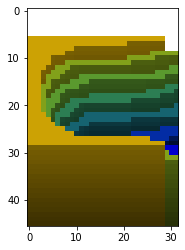

{'id': 14, 'XCoord': 912, 'YCoord': 16}


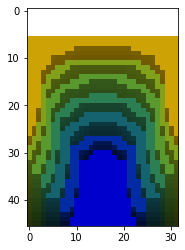

{'id': 15, 'XCoord': 976, 'YCoord': 16}


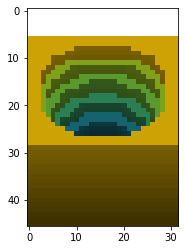

{'id': 16, 'XCoord': 16, 'YCoord': 80}


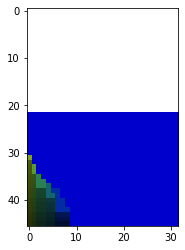

{'id': 17, 'XCoord': 80, 'YCoord': 80}


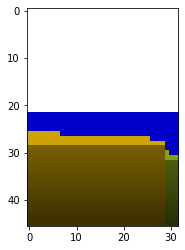

{'id': 18, 'XCoord': 144, 'YCoord': 80}


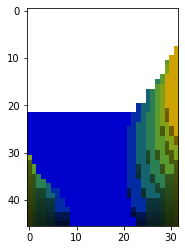

{'id': 19, 'XCoord': 208, 'YCoord': 80}


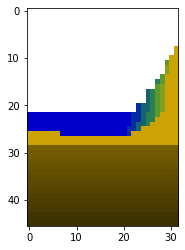

{'id': 20, 'XCoord': 272, 'YCoord': 80}


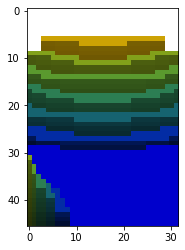

{'id': 21, 'XCoord': 336, 'YCoord': 80}


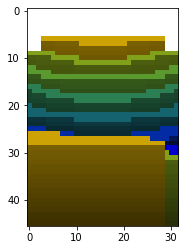

{'id': 22, 'XCoord': 400, 'YCoord': 80}


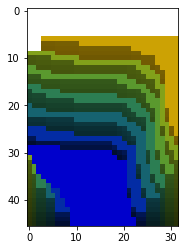

{'id': 23, 'XCoord': 464, 'YCoord': 80}


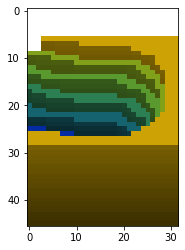

{'id': 24, 'XCoord': 528, 'YCoord': 80}


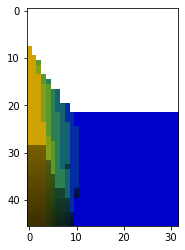

{'id': 25, 'XCoord': 592, 'YCoord': 80}


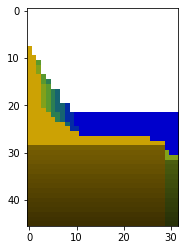

{'id': 26, 'XCoord': 656, 'YCoord': 80}


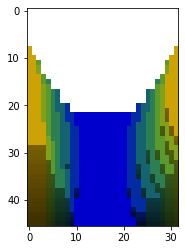

{'id': 27, 'XCoord': 720, 'YCoord': 80}


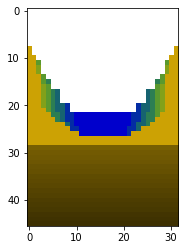

{'id': 28, 'XCoord': 784, 'YCoord': 80}


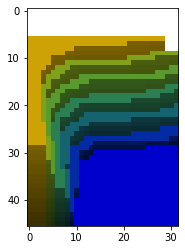

{'id': 29, 'XCoord': 848, 'YCoord': 80}


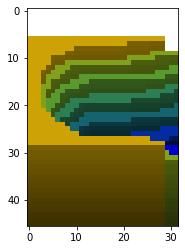

{'id': 30, 'XCoord': 912, 'YCoord': 80}


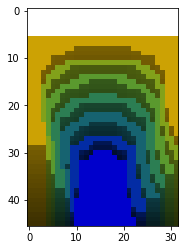

{'id': 31, 'XCoord': 976, 'YCoord': 80}


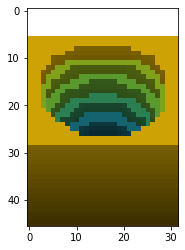

{'id': 32, 'XCoord': 16, 'YCoord': 144}


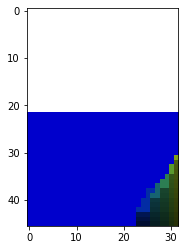

{'id': 33, 'XCoord': 80, 'YCoord': 144}


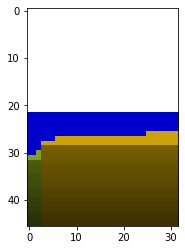

{'id': 34, 'XCoord': 144, 'YCoord': 144}


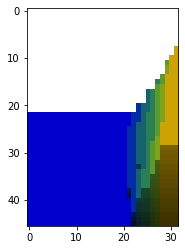

{'id': 35, 'XCoord': 208, 'YCoord': 144}


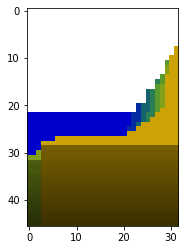

{'id': 36, 'XCoord': 272, 'YCoord': 144}


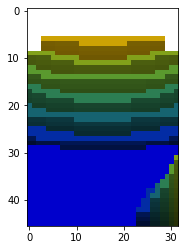

{'id': 37, 'XCoord': 336, 'YCoord': 144}


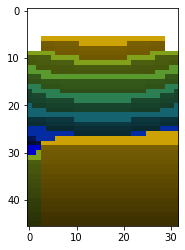

{'id': 38, 'XCoord': 400, 'YCoord': 144}


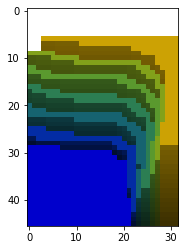

{'id': 39, 'XCoord': 464, 'YCoord': 144}


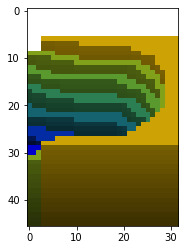

{'id': 40, 'XCoord': 528, 'YCoord': 144}


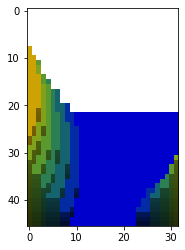

{'id': 41, 'XCoord': 592, 'YCoord': 144}


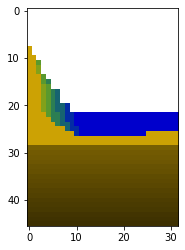

{'id': 42, 'XCoord': 656, 'YCoord': 144}


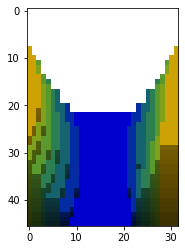

{'id': 43, 'XCoord': 720, 'YCoord': 144}


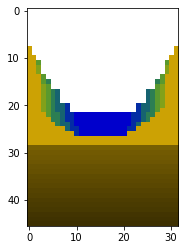

{'id': 44, 'XCoord': 784, 'YCoord': 144}


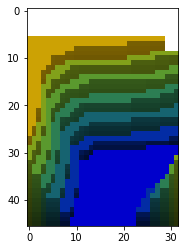

{'id': 45, 'XCoord': 848, 'YCoord': 144}


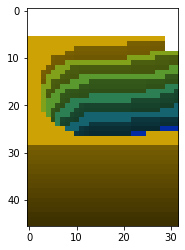

{'id': 46, 'XCoord': 912, 'YCoord': 144}


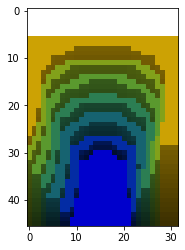

{'id': 47, 'XCoord': 976, 'YCoord': 144}


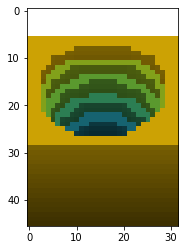

{'id': 48, 'XCoord': 16, 'YCoord': 208}


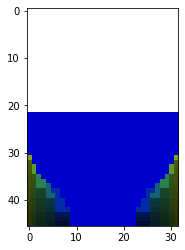

{'id': 49, 'XCoord': 80, 'YCoord': 208}


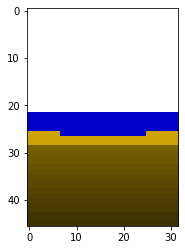

{'id': 50, 'XCoord': 144, 'YCoord': 208}


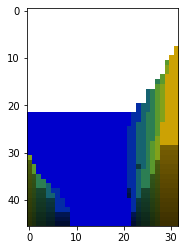

{'id': 51, 'XCoord': 208, 'YCoord': 208}


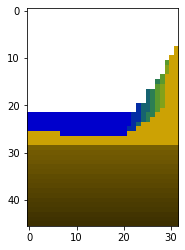

{'id': 52, 'XCoord': 272, 'YCoord': 208}


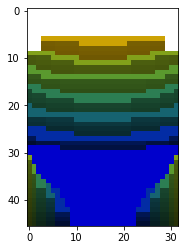

{'id': 53, 'XCoord': 336, 'YCoord': 208}


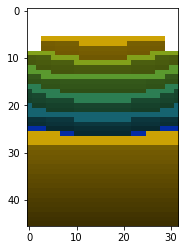

{'id': 54, 'XCoord': 400, 'YCoord': 208}


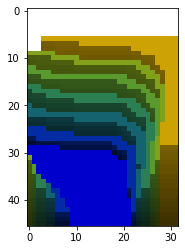

{'id': 55, 'XCoord': 464, 'YCoord': 208}


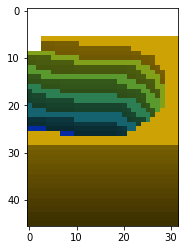

{'id': 56, 'XCoord': 528, 'YCoord': 208}


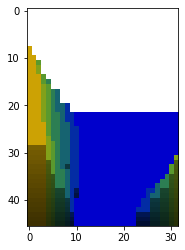

{'id': 57, 'XCoord': 592, 'YCoord': 208}


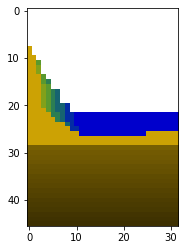

{'id': 58, 'XCoord': 656, 'YCoord': 208}


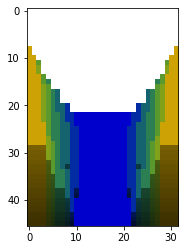

{'id': 59, 'XCoord': 720, 'YCoord': 208}


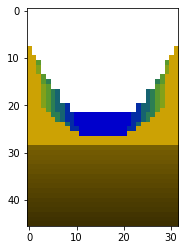

{'id': 60, 'XCoord': 784, 'YCoord': 208}


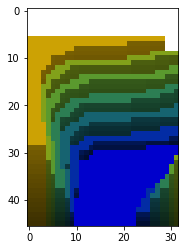

{'id': 61, 'XCoord': 848, 'YCoord': 208}


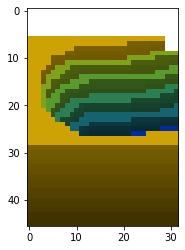

{'id': 62, 'XCoord': 912, 'YCoord': 208}


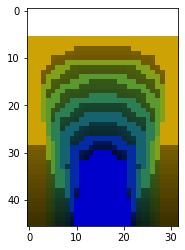

{'id': 63, 'XCoord': 976, 'YCoord': 208}


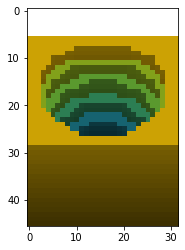

{'id': 64, 'XCoord': 16, 'YCoord': 272}


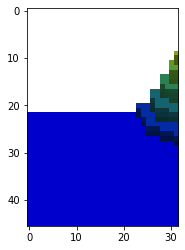

{'id': 65, 'XCoord': 80, 'YCoord': 272}


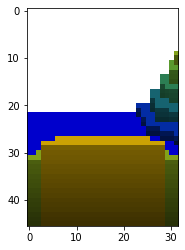

{'id': 66, 'XCoord': 144, 'YCoord': 272}


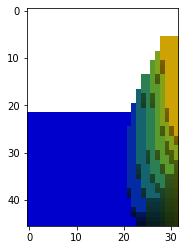

{'id': 67, 'XCoord': 208, 'YCoord': 272}


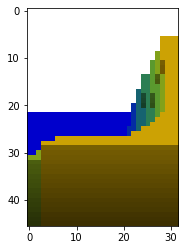

{'id': 68, 'XCoord': 272, 'YCoord': 272}


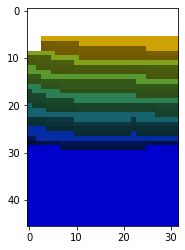

{'id': 69, 'XCoord': 336, 'YCoord': 272}


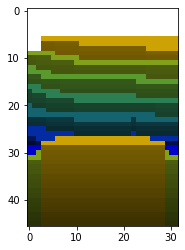

{'id': 70, 'XCoord': 400, 'YCoord': 272}


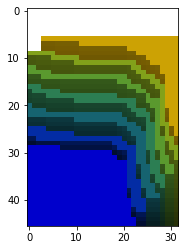

{'id': 71, 'XCoord': 464, 'YCoord': 272}


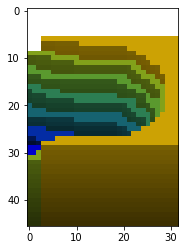

{'id': 72, 'XCoord': 528, 'YCoord': 272}


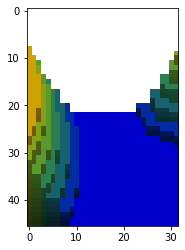

{'id': 73, 'XCoord': 592, 'YCoord': 272}


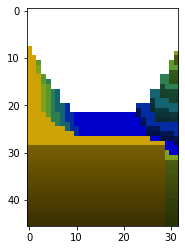

{'id': 74, 'XCoord': 656, 'YCoord': 272}


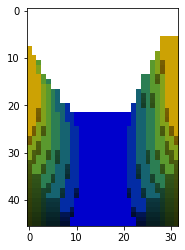

{'id': 75, 'XCoord': 720, 'YCoord': 272}


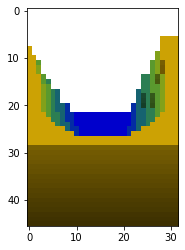

{'id': 76, 'XCoord': 784, 'YCoord': 272}


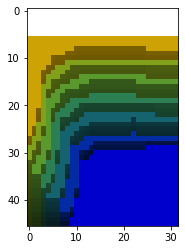

{'id': 77, 'XCoord': 848, 'YCoord': 272}


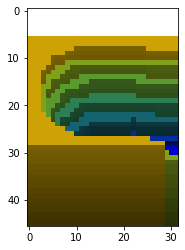

{'id': 78, 'XCoord': 912, 'YCoord': 272}


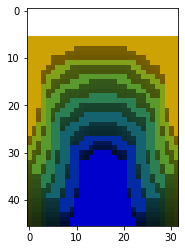

{'id': 79, 'XCoord': 976, 'YCoord': 272}


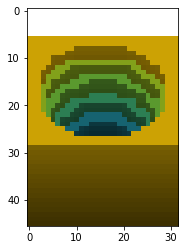

{'id': 80, 'XCoord': 16, 'YCoord': 336}


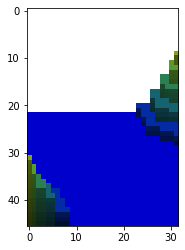

{'id': 81, 'XCoord': 80, 'YCoord': 336}


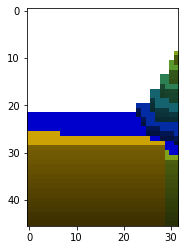

{'id': 82, 'XCoord': 144, 'YCoord': 336}


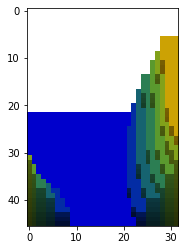

{'id': 83, 'XCoord': 208, 'YCoord': 336}


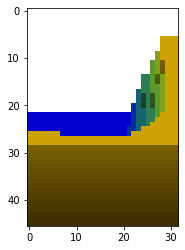

{'id': 84, 'XCoord': 272, 'YCoord': 336}


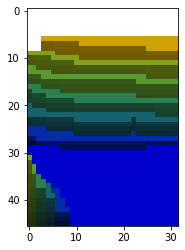

{'id': 85, 'XCoord': 336, 'YCoord': 336}


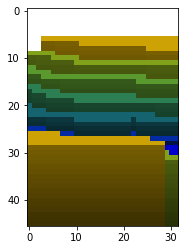

{'id': 86, 'XCoord': 400, 'YCoord': 336}


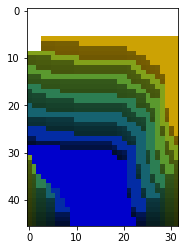

{'id': 87, 'XCoord': 464, 'YCoord': 336}


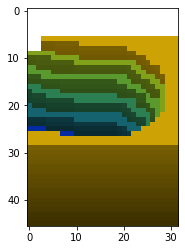

{'id': 88, 'XCoord': 528, 'YCoord': 336}


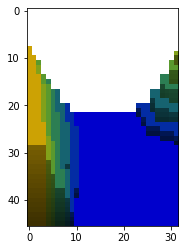

{'id': 89, 'XCoord': 592, 'YCoord': 336}


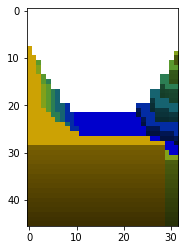

{'id': 90, 'XCoord': 656, 'YCoord': 336}


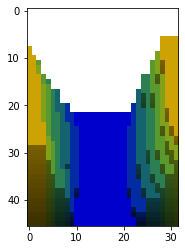

{'id': 91, 'XCoord': 720, 'YCoord': 336}


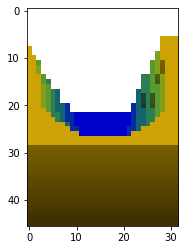

{'id': 92, 'XCoord': 784, 'YCoord': 336}


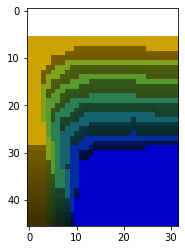

{'id': 93, 'XCoord': 848, 'YCoord': 336}


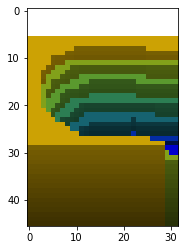

{'id': 94, 'XCoord': 912, 'YCoord': 336}


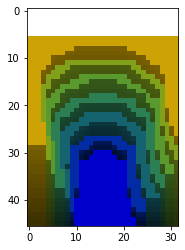

{'id': 95, 'XCoord': 976, 'YCoord': 336}


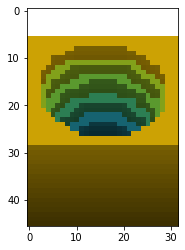

{'id': 96, 'XCoord': 16, 'YCoord': 400}


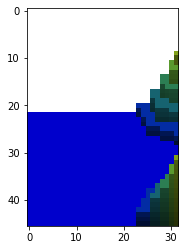

{'id': 97, 'XCoord': 80, 'YCoord': 400}


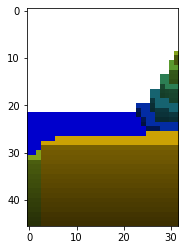

{'id': 98, 'XCoord': 144, 'YCoord': 400}


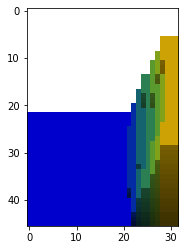

{'id': 99, 'XCoord': 208, 'YCoord': 400}


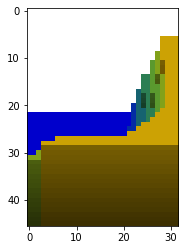

{'id': 100, 'XCoord': 272, 'YCoord': 400}


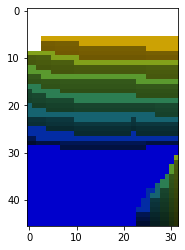

{'id': 101, 'XCoord': 336, 'YCoord': 400}


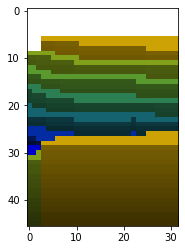

{'id': 102, 'XCoord': 400, 'YCoord': 400}


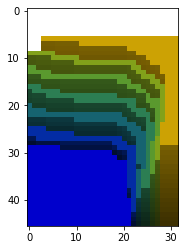

{'id': 103, 'XCoord': 464, 'YCoord': 400}


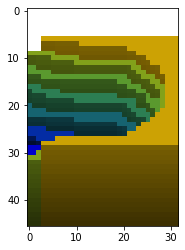

{'id': 104, 'XCoord': 528, 'YCoord': 400}


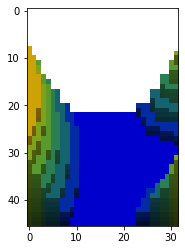

{'id': 105, 'XCoord': 592, 'YCoord': 400}


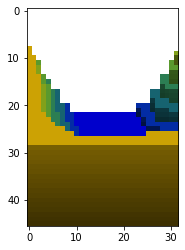

{'id': 106, 'XCoord': 656, 'YCoord': 400}


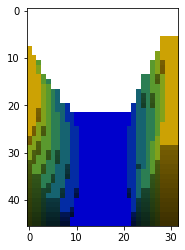

{'id': 107, 'XCoord': 720, 'YCoord': 400}


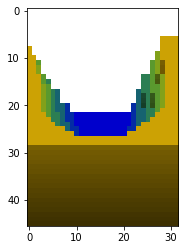

{'id': 108, 'XCoord': 784, 'YCoord': 400}


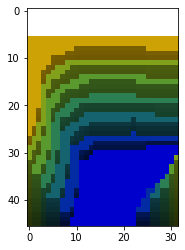

{'id': 109, 'XCoord': 848, 'YCoord': 400}


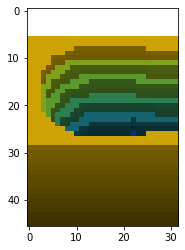

{'id': 110, 'XCoord': 912, 'YCoord': 400}


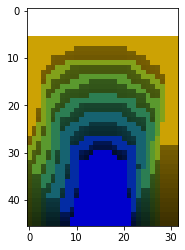

{'id': 111, 'XCoord': 976, 'YCoord': 400}


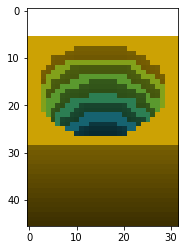

{'id': 112, 'XCoord': 16, 'YCoord': 464}


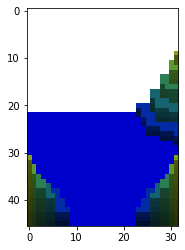

{'id': 113, 'XCoord': 80, 'YCoord': 464}


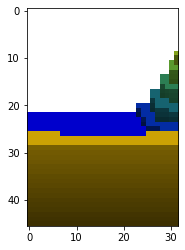

{'id': 114, 'XCoord': 144, 'YCoord': 464}


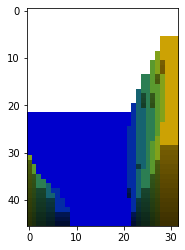

{'id': 115, 'XCoord': 208, 'YCoord': 464}


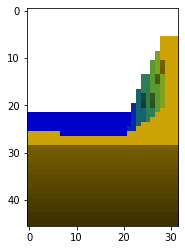

{'id': 116, 'XCoord': 272, 'YCoord': 464}


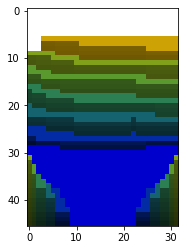

{'id': 117, 'XCoord': 336, 'YCoord': 464}


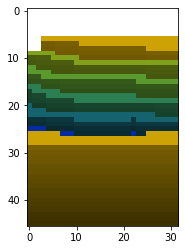

{'id': 118, 'XCoord': 400, 'YCoord': 464}


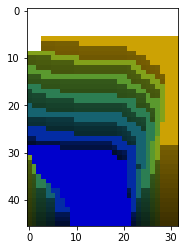

{'id': 119, 'XCoord': 464, 'YCoord': 464}


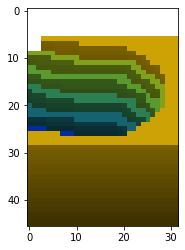

{'id': 120, 'XCoord': 528, 'YCoord': 464}


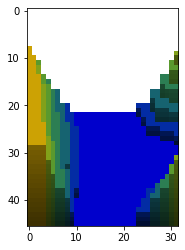

{'id': 121, 'XCoord': 592, 'YCoord': 464}


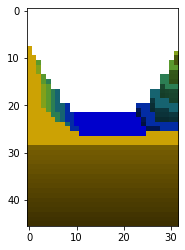

{'id': 122, 'XCoord': 656, 'YCoord': 464}


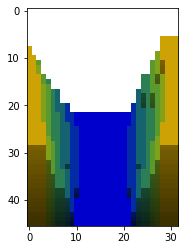

{'id': 123, 'XCoord': 720, 'YCoord': 464}


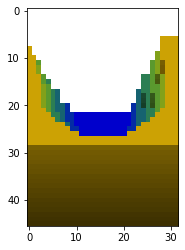

{'id': 124, 'XCoord': 784, 'YCoord': 464}


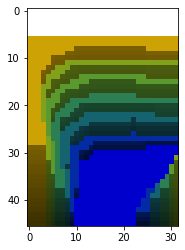

{'id': 125, 'XCoord': 848, 'YCoord': 464}


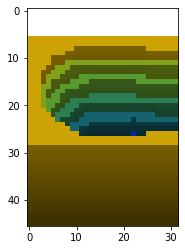

{'id': 126, 'XCoord': 912, 'YCoord': 464}


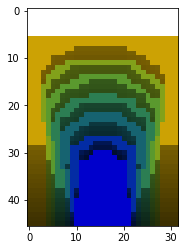

{'id': 127, 'XCoord': 976, 'YCoord': 464}


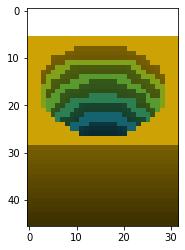

{'id': 128, 'XCoord': 16, 'YCoord': 528}


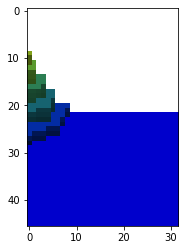

{'id': 129, 'XCoord': 80, 'YCoord': 528}


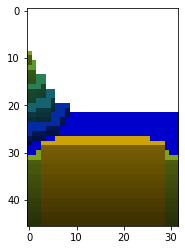

{'id': 130, 'XCoord': 144, 'YCoord': 528}


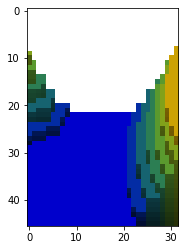

{'id': 131, 'XCoord': 208, 'YCoord': 528}


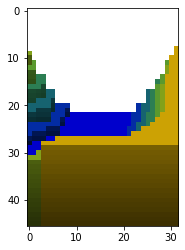

{'id': 132, 'XCoord': 272, 'YCoord': 528}


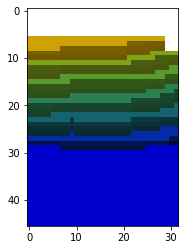

{'id': 133, 'XCoord': 336, 'YCoord': 528}


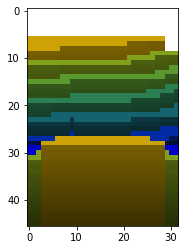

{'id': 134, 'XCoord': 400, 'YCoord': 528}


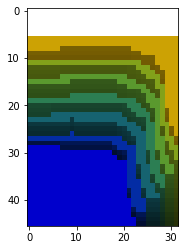

{'id': 135, 'XCoord': 464, 'YCoord': 528}


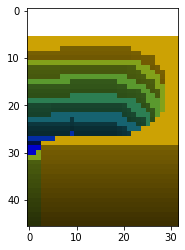

{'id': 136, 'XCoord': 528, 'YCoord': 528}


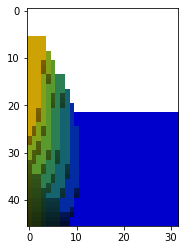

{'id': 137, 'XCoord': 592, 'YCoord': 528}


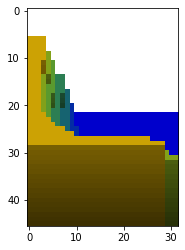

{'id': 138, 'XCoord': 656, 'YCoord': 528}


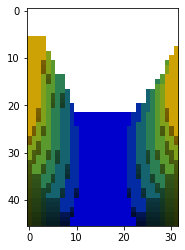

{'id': 139, 'XCoord': 720, 'YCoord': 528}


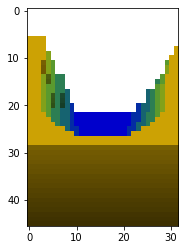

{'id': 140, 'XCoord': 784, 'YCoord': 528}


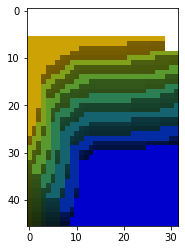

{'id': 141, 'XCoord': 848, 'YCoord': 528}


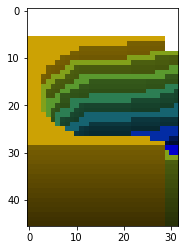

{'id': 142, 'XCoord': 912, 'YCoord': 528}


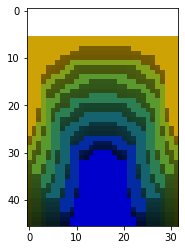

{'id': 143, 'XCoord': 976, 'YCoord': 528}


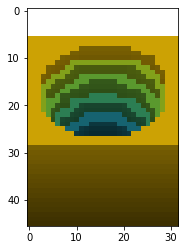

{'id': 144, 'XCoord': 16, 'YCoord': 592}


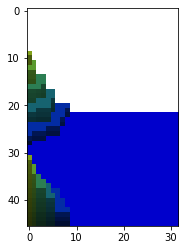

{'id': 145, 'XCoord': 80, 'YCoord': 592}


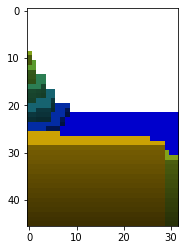

{'id': 146, 'XCoord': 144, 'YCoord': 592}


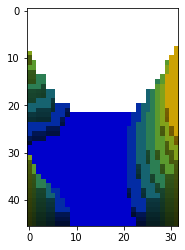

{'id': 147, 'XCoord': 208, 'YCoord': 592}


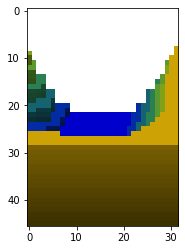

{'id': 148, 'XCoord': 272, 'YCoord': 592}


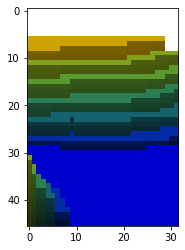

{'id': 149, 'XCoord': 336, 'YCoord': 592}


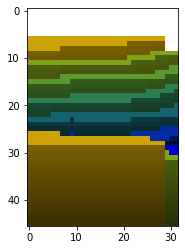

{'id': 150, 'XCoord': 400, 'YCoord': 592}


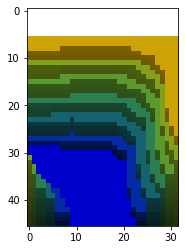

{'id': 151, 'XCoord': 464, 'YCoord': 592}


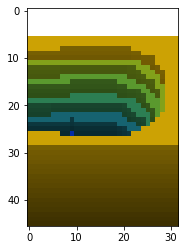

{'id': 152, 'XCoord': 528, 'YCoord': 592}


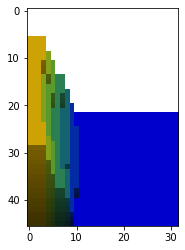

{'id': 153, 'XCoord': 592, 'YCoord': 592}


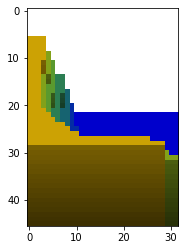

{'id': 154, 'XCoord': 656, 'YCoord': 592}


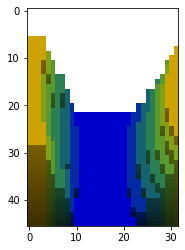

{'id': 155, 'XCoord': 720, 'YCoord': 592}


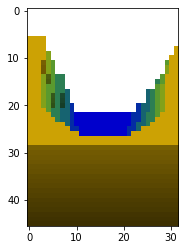

{'id': 156, 'XCoord': 784, 'YCoord': 592}


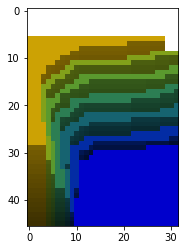

{'id': 157, 'XCoord': 848, 'YCoord': 592}


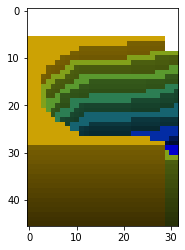

{'id': 158, 'XCoord': 912, 'YCoord': 592}


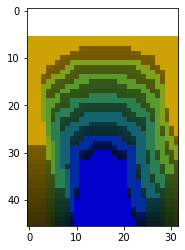

{'id': 159, 'XCoord': 976, 'YCoord': 592}


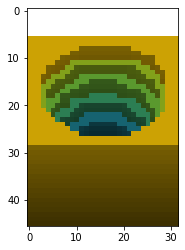

{'id': 160, 'XCoord': 16, 'YCoord': 656}


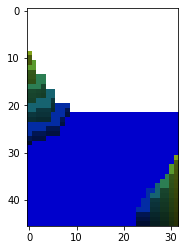

{'id': 161, 'XCoord': 80, 'YCoord': 656}


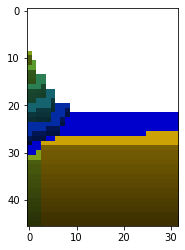

{'id': 162, 'XCoord': 144, 'YCoord': 656}


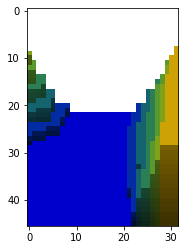

{'id': 163, 'XCoord': 208, 'YCoord': 656}


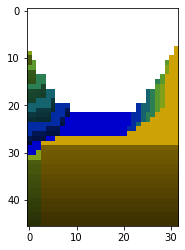

{'id': 164, 'XCoord': 272, 'YCoord': 656}


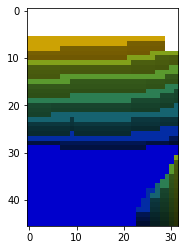

{'id': 165, 'XCoord': 336, 'YCoord': 656}


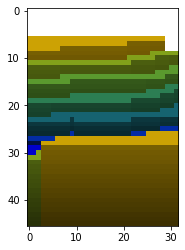

{'id': 166, 'XCoord': 400, 'YCoord': 656}


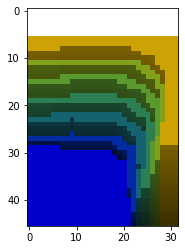

{'id': 167, 'XCoord': 464, 'YCoord': 656}


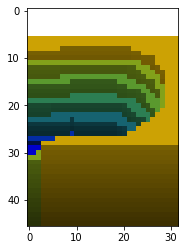

{'id': 168, 'XCoord': 528, 'YCoord': 656}


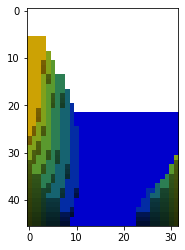

{'id': 169, 'XCoord': 592, 'YCoord': 656}


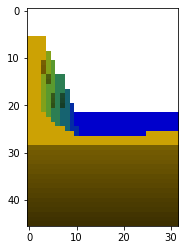

{'id': 170, 'XCoord': 656, 'YCoord': 656}


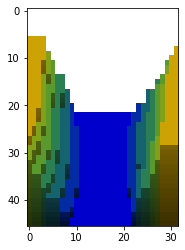

{'id': 171, 'XCoord': 720, 'YCoord': 656}


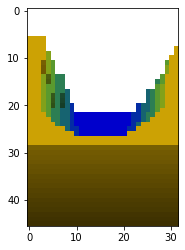

{'id': 172, 'XCoord': 784, 'YCoord': 656}


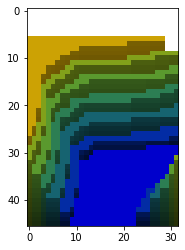

{'id': 173, 'XCoord': 848, 'YCoord': 656}


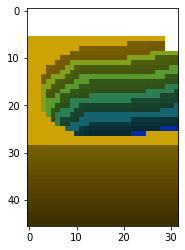

{'id': 174, 'XCoord': 912, 'YCoord': 656}


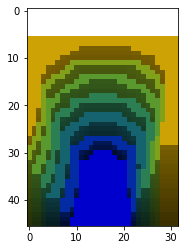

{'id': 175, 'XCoord': 976, 'YCoord': 656}


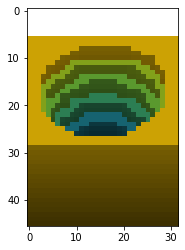

{'id': 176, 'XCoord': 16, 'YCoord': 720}


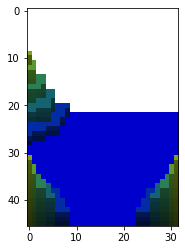

{'id': 177, 'XCoord': 80, 'YCoord': 720}


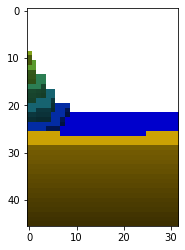

{'id': 178, 'XCoord': 144, 'YCoord': 720}


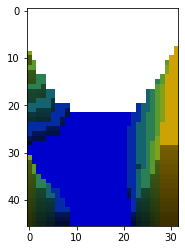

{'id': 179, 'XCoord': 208, 'YCoord': 720}


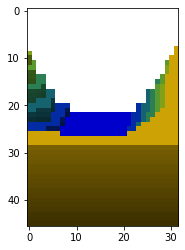

{'id': 180, 'XCoord': 272, 'YCoord': 720}


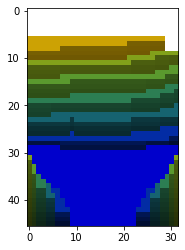

{'id': 181, 'XCoord': 336, 'YCoord': 720}


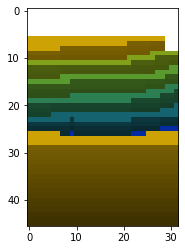

{'id': 182, 'XCoord': 400, 'YCoord': 720}


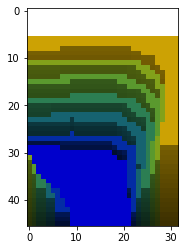

{'id': 183, 'XCoord': 464, 'YCoord': 720}


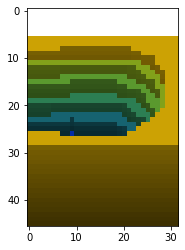

{'id': 184, 'XCoord': 528, 'YCoord': 720}


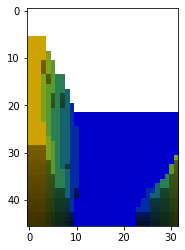

{'id': 185, 'XCoord': 592, 'YCoord': 720}


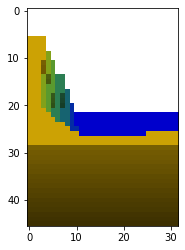

{'id': 186, 'XCoord': 656, 'YCoord': 720}


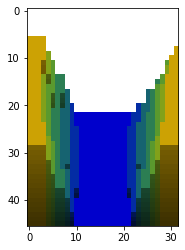

{'id': 187, 'XCoord': 720, 'YCoord': 720}


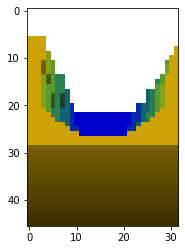

{'id': 188, 'XCoord': 784, 'YCoord': 720}


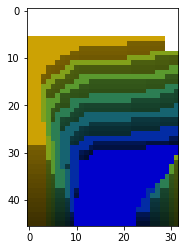

{'id': 189, 'XCoord': 848, 'YCoord': 720}


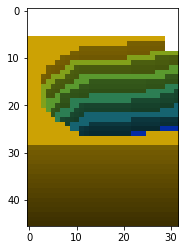

{'id': 190, 'XCoord': 912, 'YCoord': 720}


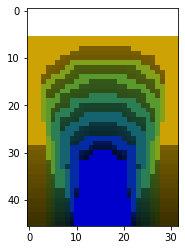

{'id': 191, 'XCoord': 976, 'YCoord': 720}


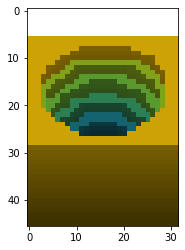

{'id': 192, 'XCoord': 16, 'YCoord': 784}


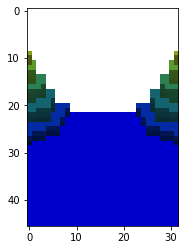

{'id': 193, 'XCoord': 80, 'YCoord': 784}


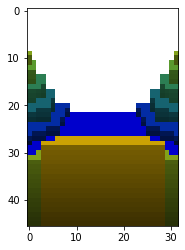

{'id': 194, 'XCoord': 144, 'YCoord': 784}


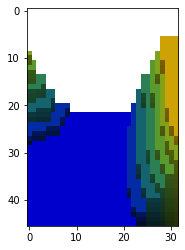

{'id': 195, 'XCoord': 208, 'YCoord': 784}


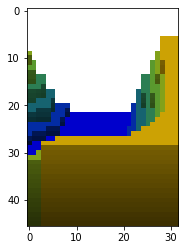

{'id': 196, 'XCoord': 272, 'YCoord': 784}


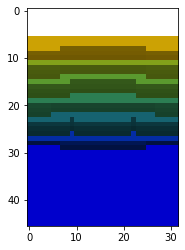

{'id': 197, 'XCoord': 336, 'YCoord': 784}


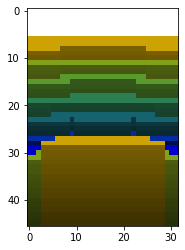

{'id': 198, 'XCoord': 400, 'YCoord': 784}


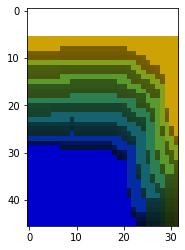

{'id': 199, 'XCoord': 464, 'YCoord': 784}


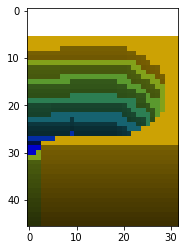

{'id': 200, 'XCoord': 528, 'YCoord': 784}


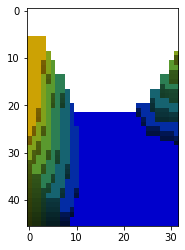

{'id': 201, 'XCoord': 592, 'YCoord': 784}


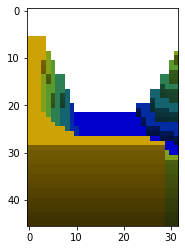

{'id': 202, 'XCoord': 656, 'YCoord': 784}


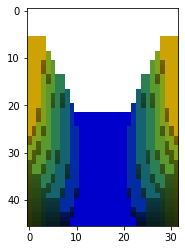

{'id': 203, 'XCoord': 720, 'YCoord': 784}


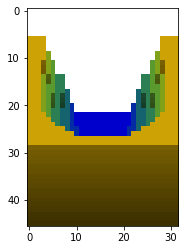

{'id': 204, 'XCoord': 784, 'YCoord': 784}


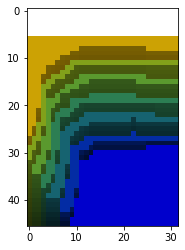

{'id': 205, 'XCoord': 848, 'YCoord': 784}


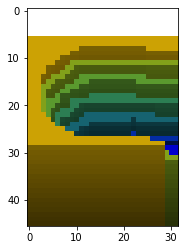

{'id': 206, 'XCoord': 912, 'YCoord': 784}


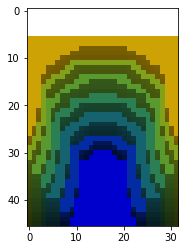

{'id': 207, 'XCoord': 976, 'YCoord': 784}


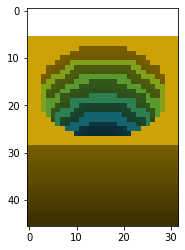

{'id': 208, 'XCoord': 16, 'YCoord': 848}


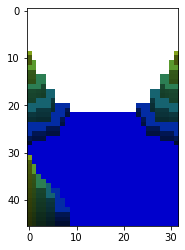

{'id': 209, 'XCoord': 80, 'YCoord': 848}


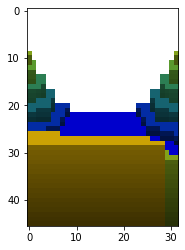

{'id': 210, 'XCoord': 144, 'YCoord': 848}


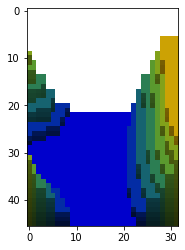

{'id': 211, 'XCoord': 208, 'YCoord': 848}


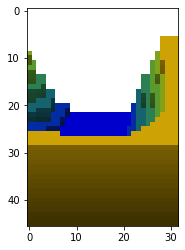

{'id': 212, 'XCoord': 272, 'YCoord': 848}


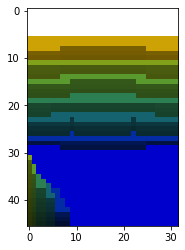

{'id': 213, 'XCoord': 336, 'YCoord': 848}


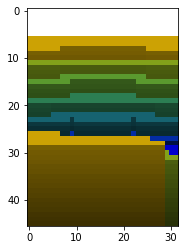

{'id': 214, 'XCoord': 400, 'YCoord': 848}


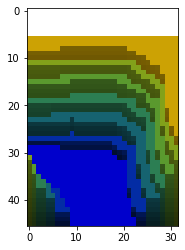

{'id': 215, 'XCoord': 464, 'YCoord': 848}


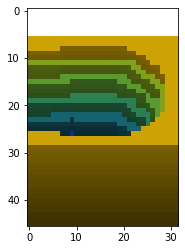

{'id': 216, 'XCoord': 528, 'YCoord': 848}


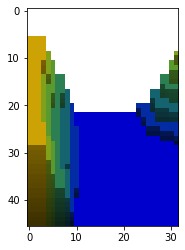

{'id': 217, 'XCoord': 592, 'YCoord': 848}


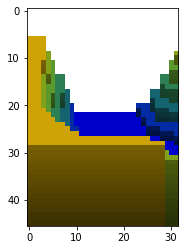

{'id': 218, 'XCoord': 656, 'YCoord': 848}


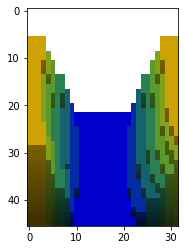

{'id': 219, 'XCoord': 720, 'YCoord': 848}


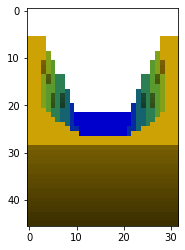

{'id': 220, 'XCoord': 784, 'YCoord': 848}


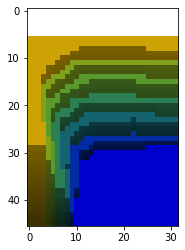

{'id': 221, 'XCoord': 848, 'YCoord': 848}


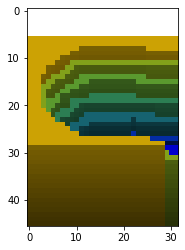

{'id': 222, 'XCoord': 912, 'YCoord': 848}


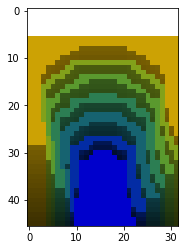

{'id': 223, 'XCoord': 976, 'YCoord': 848}


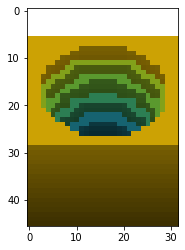

{'id': 224, 'XCoord': 16, 'YCoord': 912}


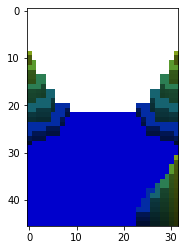

{'id': 225, 'XCoord': 80, 'YCoord': 912}


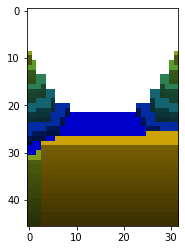

{'id': 226, 'XCoord': 144, 'YCoord': 912}


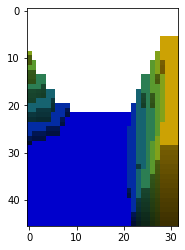

{'id': 227, 'XCoord': 208, 'YCoord': 912}


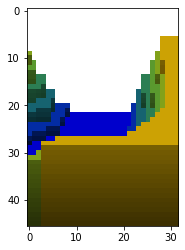

{'id': 228, 'XCoord': 272, 'YCoord': 912}


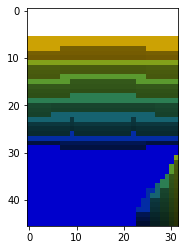

{'id': 229, 'XCoord': 336, 'YCoord': 912}


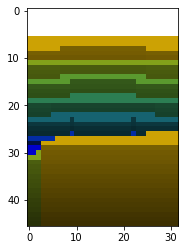

{'id': 230, 'XCoord': 400, 'YCoord': 912}


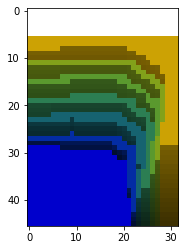

{'id': 231, 'XCoord': 464, 'YCoord': 912}


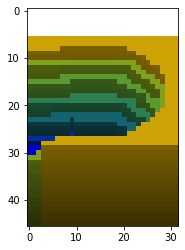

{'id': 232, 'XCoord': 528, 'YCoord': 912}


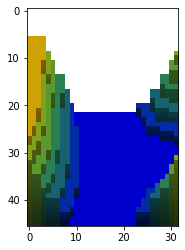

{'id': 233, 'XCoord': 592, 'YCoord': 912}


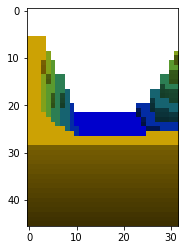

{'id': 234, 'XCoord': 656, 'YCoord': 912}


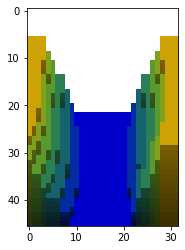

{'id': 235, 'XCoord': 720, 'YCoord': 912}


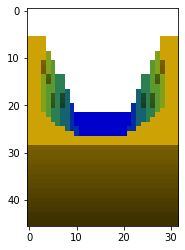

{'id': 236, 'XCoord': 784, 'YCoord': 912}


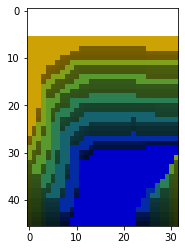

{'id': 237, 'XCoord': 848, 'YCoord': 912}


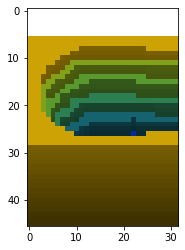

{'id': 238, 'XCoord': 912, 'YCoord': 912}


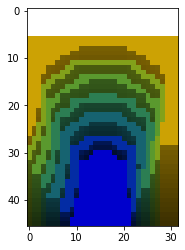

{'id': 239, 'XCoord': 976, 'YCoord': 912}


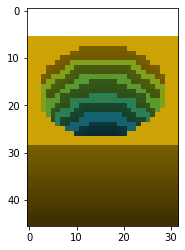

{'id': 240, 'XCoord': 16, 'YCoord': 976}


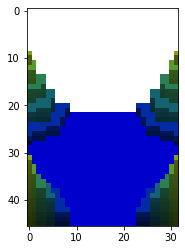

{'id': 241, 'XCoord': 80, 'YCoord': 976}


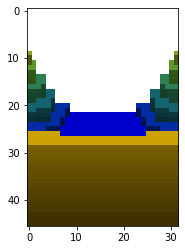

{'id': 242, 'XCoord': 144, 'YCoord': 976}


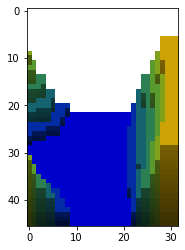

{'id': 243, 'XCoord': 208, 'YCoord': 976}


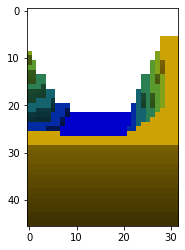

{'id': 244, 'XCoord': 272, 'YCoord': 976}


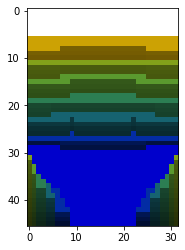

{'id': 245, 'XCoord': 336, 'YCoord': 976}


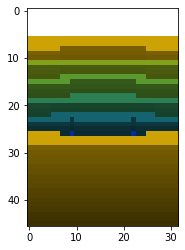

{'id': 246, 'XCoord': 400, 'YCoord': 976}


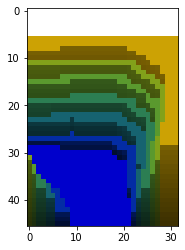

{'id': 247, 'XCoord': 464, 'YCoord': 976}


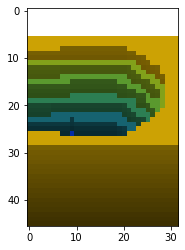

{'id': 248, 'XCoord': 528, 'YCoord': 976}


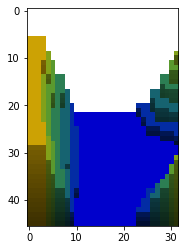

{'id': 249, 'XCoord': 592, 'YCoord': 976}


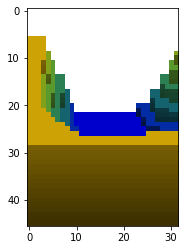

{'id': 250, 'XCoord': 656, 'YCoord': 976}


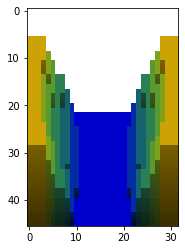

{'id': 251, 'XCoord': 720, 'YCoord': 976}


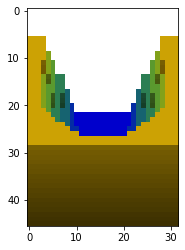

{'id': 252, 'XCoord': 784, 'YCoord': 976}


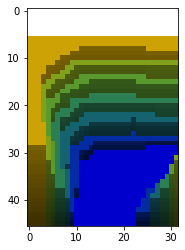

{'id': 253, 'XCoord': 848, 'YCoord': 976}


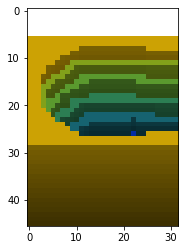

{'id': 254, 'XCoord': 912, 'YCoord': 976}


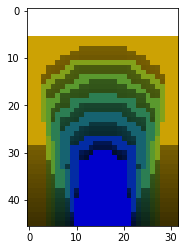

{'id': 255, 'XCoord': 976, 'YCoord': 976}


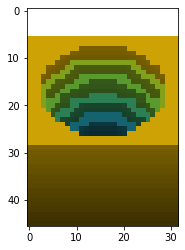

{'id': 256, 'XCoord': 16, 'YCoord': 1040}


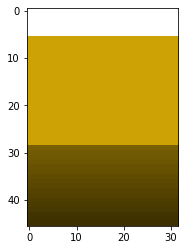

In [53]:
W = 32
H = 23
FullH = H * 2
max_v = 255
h_steps = 6

for tile_info in tiles_info:
	print(tile_info)
	img = Image.new('RGBA', (W, FullH), (0, 0, 0, 0))
	pixels = img.load()
	x0, y0 = 0, 0
	w, h = img.size[0], img.size[1]
	hpos, vpos = int(tile_info['XCoord']), int(tile_info['YCoord'])
	for ry in range(src_base_h):
		y = src_base_h - ry - 1  
		for x in range(src_base_w):
			hoff = hpos # * src_base_w
			voff = vpos # * src_base_h
			sx = x + hoff
			sy = y + voff

			try:
				rv, gv, bv, av = tiles_img.getpixel((sx, sy))
			except:
				print(f"hoff={hoff}, voff={voff}, x={x}, y={y}, sx={sx}, sy={sy}, "
					  f"src_base_w={src_base_w}, src_base_h={src_base_h}")
				raise

			v = max(rv, gv, bv, 2)
			if v > 1:
				cv = ( int( v / max_v * h_steps ) / h_steps ) * 15
				r, g, b = gradient[int(cv)]
				r, g, b = int(r * .8), int(g * .8), int(b * .8)

				#tv = v / max_v
				tv = int( v / max_v * h_steps ) / h_steps
				v = int(tv * H)
				for iv in range(0, v):
					cf = .3 + .3 * iv / v                 
					pixels[x0 + x, (FullH - 1) - (y0 + (y + iv) * H / W)] = \
						(int(r*cf), int(g*cf), int(b*cf), 255)
				pixels[x0 + x, (FullH - 1) - (y0 + (y + v) * H / W)] = (r, g, b, 255)
    
	plt.imshow(img)
	plt.show()
